In [16]:
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.linalg import spsolve
from fealpy.boundarycondition import DirichletBC, NeumannBC

from fealpy.tools.show import showmultirate, show_error_table


In [26]:
import numpy as np
import cv2
import queue, threading, time
from configparser import ConfigParser
from numpy.core.numeric import zeros_like
import matplotlib.pyplot as plt
import colorsys
import math
import random
from vidgear.gears import VideoGear
from vidgear.gears import WriteGear
import datetime
import os
import csv
import json
from mpl_toolkits.mplot3d import Axes3D
# 导出mag ang数据

    
# 读取mag or ang数据
def read_mag_ang(txtPath):
    return np.loadtxt(txtPath)

mag = read_mag_ang('./save_20230413_095857_frame_109_size_800_600/mag.txt')
mag_copy = read_mag_ang('./save_20230413_095857_frame_109_size_800_600/mag_copy.txt')
ang = read_mag_ang('./save_20230413_095857_frame_109_size_800_600/ang.txt')
print(mag.shape)

# 对结果矩阵偏移的修正
horMat = np.multiply(mag_copy, np.cos(ang))
verMat = np.multiply(mag_copy, np.sin(ang))

(600, 800)


600 800


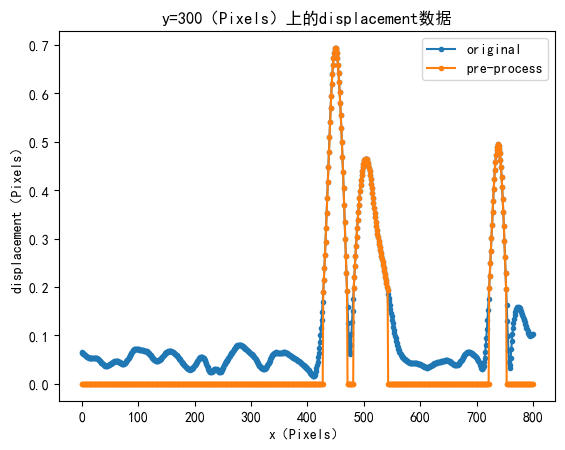

In [22]:
(h, w) = mag.shape
print(h, w)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

half_h = int(h/2)
x_axis_data = list(range(0, w))
y1_axis_data = list(mag[half_h])
y2_axis_data = list(mag_copy[half_h])
y3_axis_data = list(horMat[half_h])
y4_axis_data = list(verMat[half_h])


# plt.plot(x_axis_data, y1_axis_data, 'b', alpha=0.5, linewidth=1, label='dis')#'bo-'表示蓝色实线，数据点实心原点标注
## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，
plt.title('y={}（Pixels）上的displacement数据'.format(half_h))  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('x（Pixels）')  # x轴标题
plt.ylabel('displacement（Pixels）')  # y轴标题
plt.plot(x_axis_data, y1_axis_data, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x_axis_data, y2_axis_data, marker='o', markersize=3)
plt.legend(['original', 'pre-process'])  # 设置折线名称
plt.show()  # 显示折线图


C:\Users\18120\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


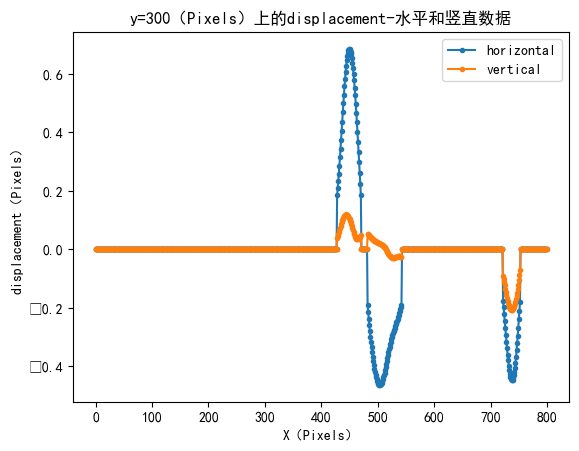

In [23]:
plt.title('y=300（Pixels）上的displacement-水平和竖直数据')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('X（Pixels）')  # x轴标题
plt.ylabel('displacement（Pixels）')  # y轴标题
plt.plot(x_axis_data, y3_axis_data, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x_axis_data, y4_axis_data, marker='o', markersize=3)
plt.legend(['horizontal', 'vertical'])  # 设置折线名称
plt.show()  # 显示折线图

In [28]:
# 自定义卷积函数
def my_conv(input, kernel, step):
    output_size_0 = int((len(input) - len(kernel)) / step + 1)   # 输出结果的第0维长度
    output_size_1 = int((len(input[0]) - len(kernel[0])) / step + 1)   # 输出结果的第1维长度
    res = np.zeros([output_size_0, output_size_1], np.float32)

    for i in range(len(res)):
        for j in range(len(res[0])):
            a = input[i*step:i*step + len(kernel), j*step: j*step + len(kernel)]  # 从输入矩阵中取出子矩阵
            b = a * kernel  # 对应元素相乘
            res[i][j] = b.sum()   
    return res
step = 10                       # 卷积模板步长
half_step = int(step/2)         # 卷积模板的半步长
kernel = np.ones((half_step, half_step)) / half_step**2
mag_conv = my_conv(mag_copy, kernel, step)
ang_conv = my_conv(ang, kernel, step)

horMat = np.multiply(mag_conv, np.cos(ang_conv))
verMat = np.multiply(mag_conv, np.sin(ang_conv))
print("magcopy shape is {} and horMat shape is {}".format(mag.shape, horMat.shape))

magcopy shape is (600, 800) and horMat shape is (60, 80)


In [26]:
import numpy as np
from fealpy.decorator import cartesian,barycentric
class possion_solution_BOS:
    def __init__(self):
        pass
    
    # 定义网格区域大小
    @property
    def domain(self):   
        return np.array([0, 4, 0, 2])

In [35]:
import numpy as np
from fealpy.decorator import cartesian,barycentric
class possion_solution:
    
    def __init__(self):
        pass
    
    # 定义网格区域大小
    @property
    def domain(self):   
        return np.array([0, 4, 0, 2])
        
    # 原项 f(x,y)，泊松方程的右边
    @cartesian
    def source(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = pi*pi*np.cos(pi*x)
        return val
    
    # 精确解u(x,y)，泊松方程的左边
    @cartesian
    def exact_solution(self, p):
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.cos(pi*x)
        return val
        
    # 真解的梯度 
    @cartesian
    def gradient(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.zeros(p.shape, dtype = np.float64)
        val[..., 0] = -pi*np.sin(pi*x)
        val[..., 1] = 0
        return val
        
    # 梯度的负方向
    @cartesian 
    def flux(self, p):
        return -self.gradient(p)
        
    #定义边界条件
    @cartesian
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (y == 0.0)|(x == 0.1)|(y == 0.1)
    
    @cartesian
    def dirichlet(self, p):
        return self.exact_solution(p)
    
    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (x == 0.0) 
        
    @cartesian
    def neumann(self, p, n):
        grad = self.gradient(p)
        val = np.sum(grad * n, axis = -1)
        return val


run boxmesh2d with time: 0.7400948000000653


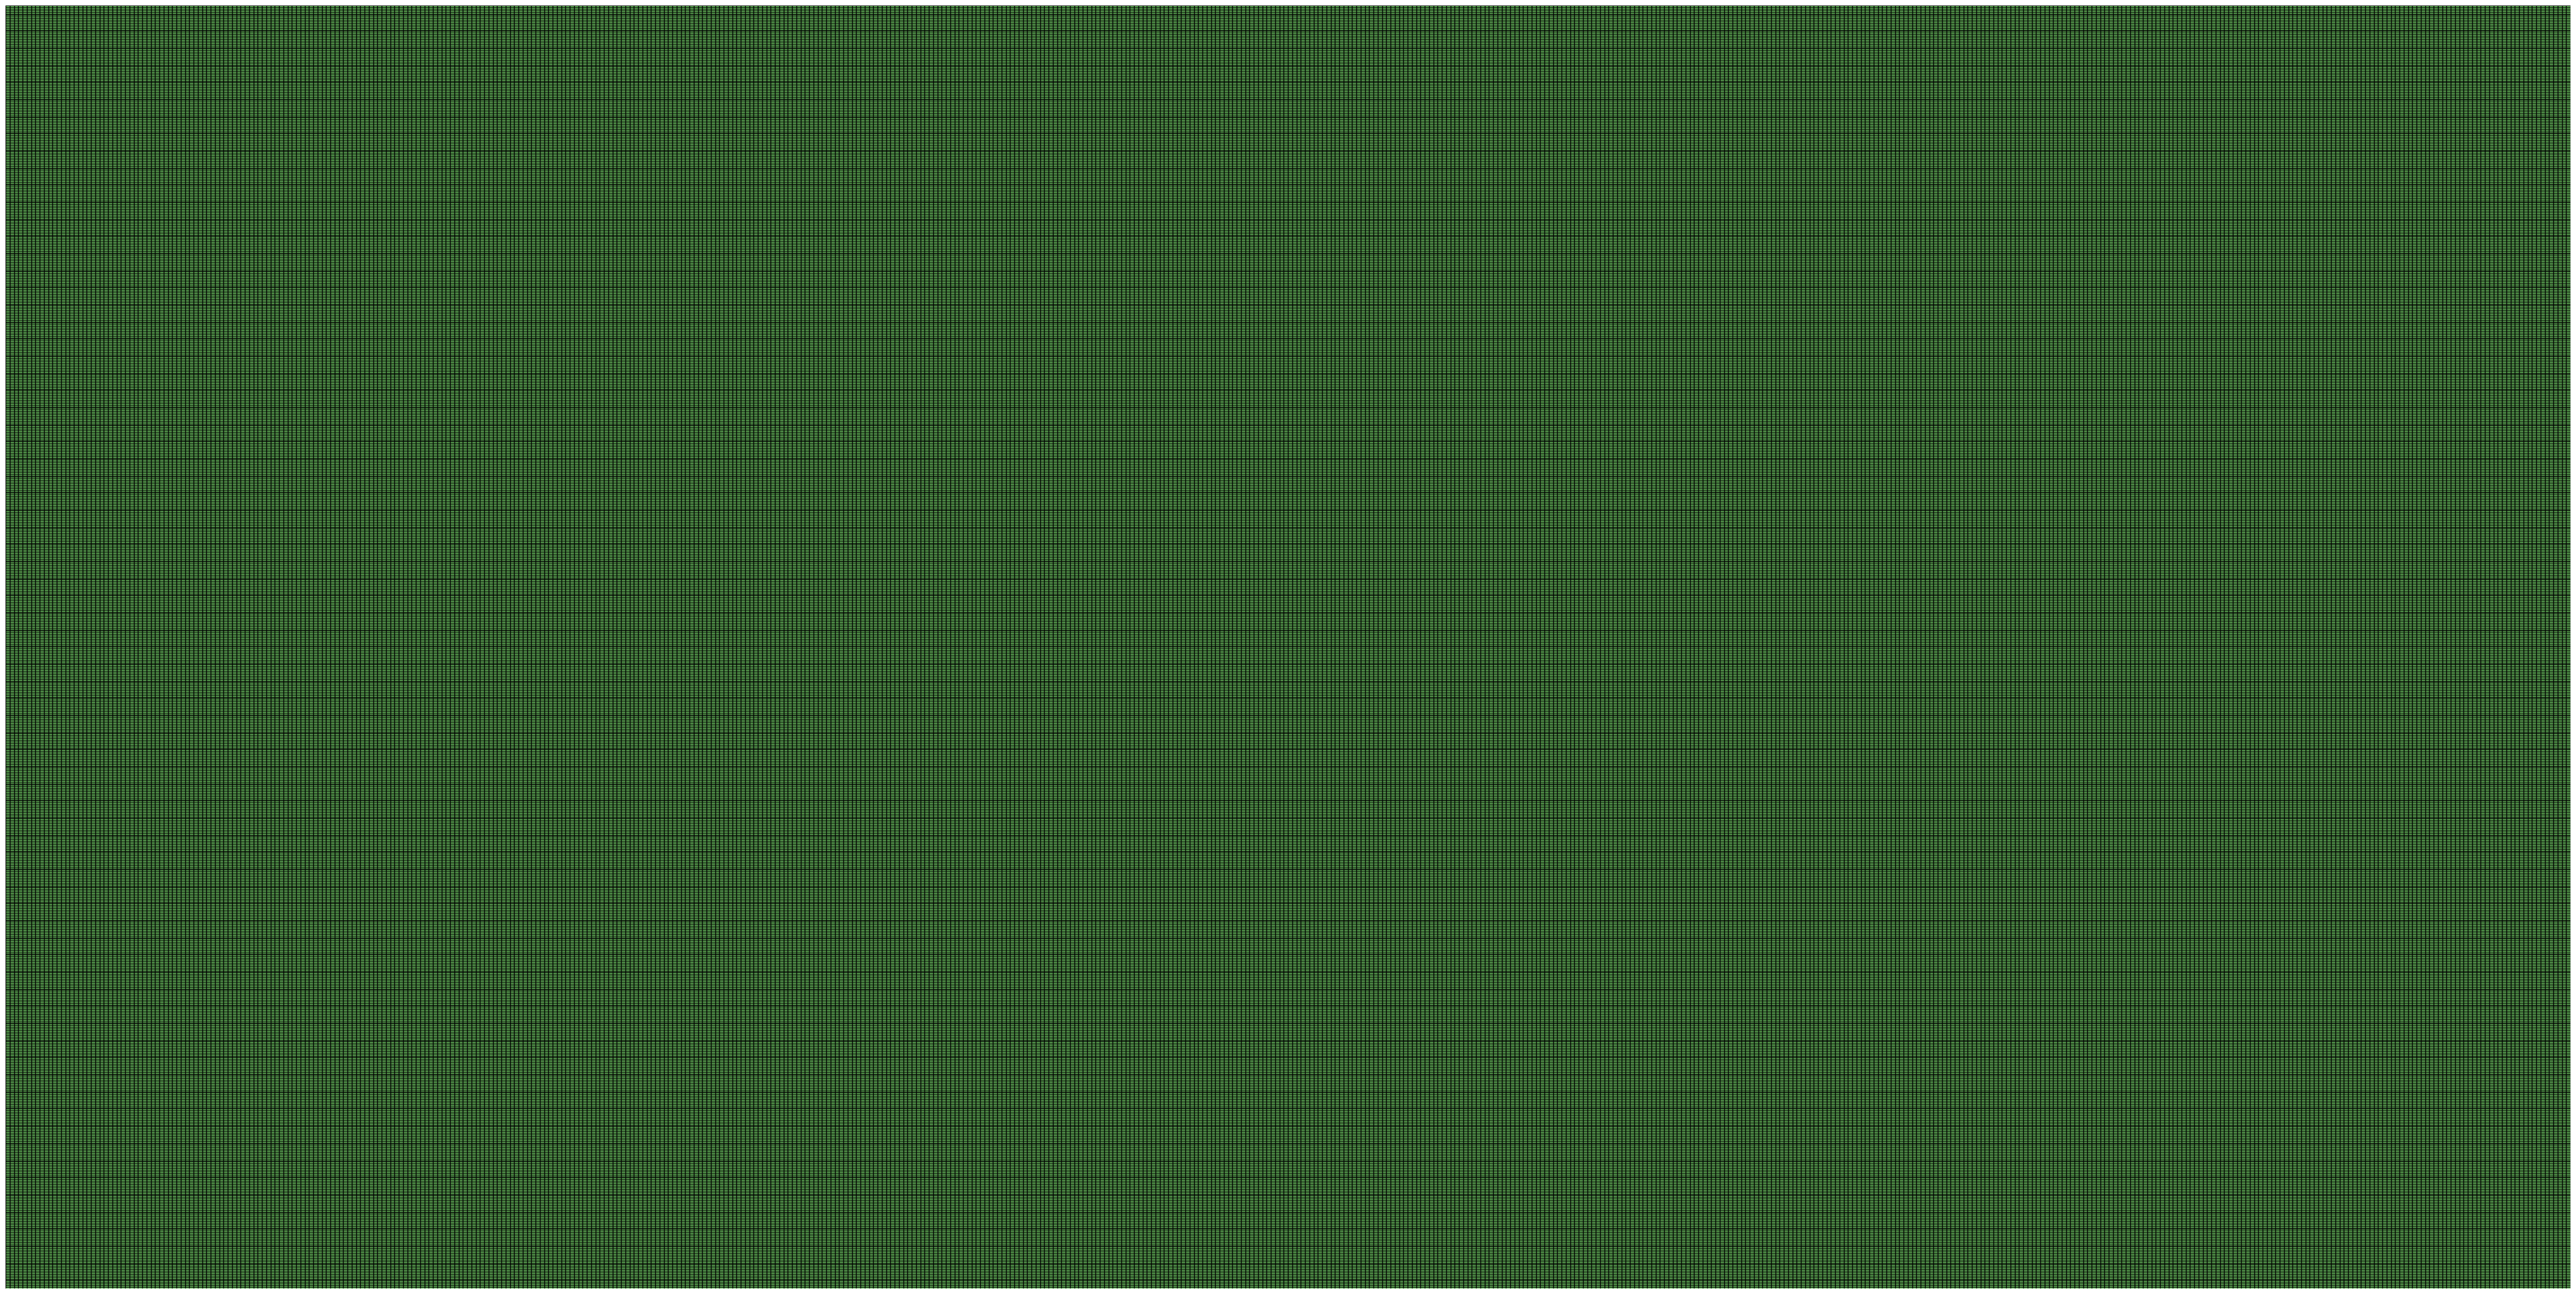

In [37]:
import numpy as np
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
%matplotlib inline

# 加载pde模型
pde = possion_solution()

# 加载网格
box = pde.domain
n = 10
mesh = MeshFactory.boxmesh2d(box, nx = 600, ny = 800, meshtype = 'quad')

# 画图
figure = plt.figure(figsize=(60,80))
axes = figure.gca()
mesh.add_plot(axes)
#mesh.find_node(axes, showindex = True)
#mesh.find_edge(axes, showindex = True)
#mesh.find_cell(axes, showindex = True)

#获取单元，网格，节点信息
#nodes = mesh.entity('node')
#cells = mesh.entity('cell')
#edges = mesh.entity('edge')


In [18]:
import sys
import numpy as np
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
%matplotlib inline
def possion_solution_solver(pde, n, refine, order): 
    """
    Input:
        @pde: 定义偏微分方程
        @n: 初始网格剖分段数
        @refine: 网格加密的最大次数（迭代求解次数）
        @order: 有限元多项式次数
    Output: None
    """
    mesh = MeshFactory.boxmesh2d(pde.domain, nx = n, ny = n, meshtype = 'tri')
    
    number_of_dofs = np.zeros(refine, dtype = mesh.itype)
    # 建立空数组，目的把每组的自由度个数存下来
    error_matrix = np.zeros((2, refine), dtype = mesh.ftype)
    error_type = ['$||u - u^{h}||_{0}$', '$||\\nabla u - \\nabla u^{h}||_{0}$']
    
    for i in range(refine):
        femspace = LagrangeFiniteElementSpace(mesh, p = order)
        number_of_dofs[i] = femspace.number_of_global_dofs()
        uh = femspace.function() 
        # 返回一个有限元函数，初始自由度值全为 0
        
        # A·u = b + b_n
        
        A = femspace.stiff_matrix()
        F = femspace.source_vector(pde.source)
        # 先计算纽曼
        bc = NeumannBC(femspace, pde.neumann, threshold = pde.is_neumann_boundary)
        F = bc.apply(F)
        
        #最后计算Dirichlet
        bc = DirichletBC(femspace, pde.dirichlet, threshold = pde.is_dirichlet_boundary)
        A, F = bc.apply(A, F, uh)
        
        uh[:] = spsolve(A, F)
        
        #计算误差
        error_matrix[0, i] = femspace.integralalg.L2_error(pde.exact_solution, uh.value)
        error_matrix[1, i] = femspace.integralalg.L2_error(pde.gradient, uh.grad_value)
        
        print('插值点: ', femspace.interpolation_points().shape)
        print('自由度数（NDof）: ', number_of_dofs[i])
        nodes = mesh.entity('node')
        print('节点数: ', nodes.shape)
        if i < refine - 1:
            mesh.uniform_refine()
    
    fig = plt.figure()
    plt.rcParams [ 'axes.unicode_minus' ]= False 
    axes = fig.add_subplot(projection='3d')
    uh.add_plot(axes, cmap = 'rainbow')
    showmultirate(plt, 0, number_of_dofs, error_matrix, error_type, propsize = 20)
    show_error_table(number_of_dofs, error_type, error_matrix, f='e', pre=4, sep=' & ', out=sys.stdout, end='\n')
    plt.show()


In [39]:
possion_solution_solver(possion_solution(), 40, 1, 1)


run boxmesh2d with time: 0.0043962999999394015
run serial_construct_matrix with time: 0.037427399999955924
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.1583307999999306
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (6561, 2)
run serial_construct_matrix with time: 0.5925247999999783
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (25921, 2)
run serial_construct_matrix with time: 2.3559838999999556
插值点:  (103041, 2)
自由度数（NDof）:  103041
节点数:  (103041, 2)
run serial_construct_matrix with time: 9.486971700000026
插值点:  (410881, 2)
自由度数（NDof）:  410881
节点数:  (410881, 2)
\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &   1681 &   6561 &  25921 & 103041 & 410881
\\\hline
$||u - u^{h}||_{0}$ & 1.8103e-02 & 4.5348e-03 & 1.1343e-03 & 2.8361e-04 & 7.0905e-05
\\\hline
Order & -- & 2. & 2. & 2. & 2.
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 5.6876e-01 & 2.8478e-01 & 1.4244e-01 & 7.1226e-02 & 3.5614e-02
\\\hline
Order & -- & 1. & 1. & 1. & 1.
\\\hl

run boxmesh2d with time: 0.0006911999999772434
run serial_construct_matrix with time: 0.007419599999991533
插值点:  (441, 2)
自由度数（NDof）:  441
节点数:  (121, 2)
run serial_construct_matrix with time: 0.027713200000022198
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (441, 2)
run serial_construct_matrix with time: 0.10949480000002154
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.44864069999999856
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (6561, 2)
run serial_construct_matrix with time: 1.7415214000000105
插值点:  (103041, 2)
自由度数（NDof）:  103041
节点数:  (25921, 2)
\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &    441 &   1681 &   6561 &  25921 & 103041
\\\hline
$||u - u^{h}||_{0}$ & 2.7794e-04 & 3.5007e-05 & 4.3913e-06 & 5.4980e-07 & 6.8778e-08
\\\hline
Order & -- & 2.99 & 2.99 & 3.   & 3.  
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 2.1248e-02 & 5.3680e-03 & 1.3472e-03 & 3.3733e-04 & 8.4392e-05
\\\hline
Order & -- & 1.98 & 1.99 & 2.   & 2

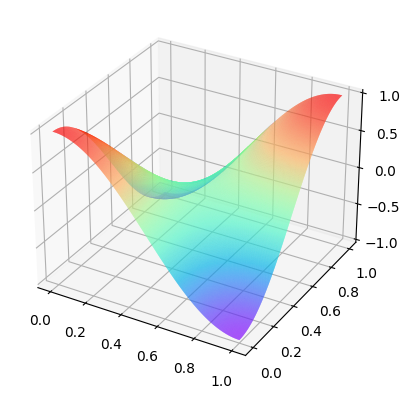

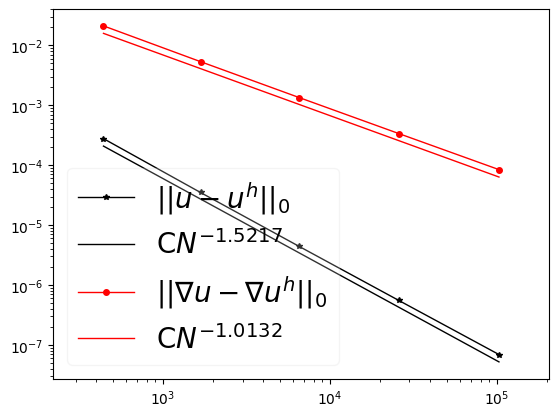

In [10]:
possion_solution_solver(possion_solution(), 10, 5, 2)


In [14]:
def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (y == 0.0) & ( x <b) & (x > a) 
    
@cartesian
def dirichlet(self, p):
    val = val * np.ones(len(p))
    return val
